In [1]:
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого
_, test_loader, train_loader_no_augumentation, valid_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=10112*2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 200
run_num = 5 # количество запусков эксперимента
# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '6' 

validate_every_epoch = 5 # каждые 5 эпох отслеживать параметры модели

# с этими гиперпараметрами мы начинаем эксперименты
start_beta = 0.9914 #0.3 
start_temp  = 6.5 #10**(0.5)

In [31]:
def accuracy(student):
        student.eval()
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        student.train()
        return (correct/total).cpu().detach().numpy()

In [34]:
# запуск без дистилляции
for _ in range(run_num):
    internal_results = []
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())    
    crit = nn.CrossEntropyLoss()
    for e in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for x,y in tq:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()            
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))        
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc})
            print (internal_results[-1])

    with open('exp'+experiment_version+'_basic.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

current loss:1.6448382139205933:   5%|▌         | 4/79 [00:00<00:01, 38.85it/s]

{'epoch': 0, 'test loss': 1.6584702730178833, 'accuracy': 0.3919999897480011}


current loss:1.2056939601898193:   5%|▌         | 4/79 [00:00<00:01, 39.17it/s]

{'epoch': 4, 'test loss': 1.3372619152069092, 'accuracy': 0.5212999582290649}


current loss:0.9908003807067871:   5%|▌         | 4/79 [00:00<00:01, 39.09it/s]

{'epoch': 9, 'test loss': 1.3128234148025513, 'accuracy': 0.5396000146865845}


current loss:0.8602039217948914:   5%|▌         | 4/79 [00:00<00:02, 36.37it/s]

{'epoch': 14, 'test loss': 1.348897099494934, 'accuracy': 0.5379999876022339}


current loss:0.7722415328025818:   5%|▌         | 4/79 [00:00<00:01, 37.57it/s]

{'epoch': 19, 'test loss': 1.4245972633361816, 'accuracy': 0.5310999751091003}


current loss:0.7140291333198547:   5%|▌         | 4/79 [00:00<00:01, 37.97it/s]

{'epoch': 24, 'test loss': 1.501477837562561, 'accuracy': 0.5356999635696411}


current loss:0.6453399658203125:   5%|▌         | 4/79 [00:00<00:01, 39.68it/s]

{'epoch': 29, 'test loss': 1.6829416751861572, 'accuracy': 0.5202999711036682}


current loss:0.634465754032135:   5%|▌         | 4/79 [00:00<00:02, 37.34it/s] 

{'epoch': 34, 'test loss': 1.8815585374832153, 'accuracy': 0.4980999827384949}


current loss:0.5239022970199585:   6%|▋         | 5/79 [00:00<00:01, 40.50it/s]

{'epoch': 39, 'test loss': 1.82413649559021, 'accuracy': 0.5178999900817871}


current loss:0.4895573854446411:   6%|▋         | 5/79 [00:00<00:01, 42.02it/s] 

{'epoch': 44, 'test loss': 1.9748332500457764, 'accuracy': 0.5110999941825867}


current loss:0.49121224880218506:   6%|▋         | 5/79 [00:00<00:01, 41.08it/s]

{'epoch': 49, 'test loss': 2.0832743644714355, 'accuracy': 0.5034999847412109}


current loss:0.4265713691711426:   6%|▋         | 5/79 [00:00<00:01, 41.08it/s] 

{'epoch': 54, 'test loss': 2.1079154014587402, 'accuracy': 0.5110999941825867}


current loss:0.3653407096862793:   6%|▋         | 5/79 [00:00<00:01, 40.15it/s] 

{'epoch': 59, 'test loss': 2.1813197135925293, 'accuracy': 0.515500009059906}


current loss:0.31391382217407227:   6%|▋         | 5/79 [00:00<00:01, 42.33it/s]

{'epoch': 64, 'test loss': 2.315239429473877, 'accuracy': 0.5081999897956848}


current loss:0.32999104261398315:   6%|▋         | 5/79 [00:00<00:01, 40.38it/s]

{'epoch': 69, 'test loss': 2.6850669384002686, 'accuracy': 0.4860999882221222}


current loss:0.3718755841255188:   6%|▋         | 5/79 [00:00<00:01, 41.05it/s]

{'epoch': 74, 'test loss': 2.7771055698394775, 'accuracy': 0.4900999963283539}


current loss:0.2700386941432953:   5%|▌         | 4/79 [00:00<00:01, 39.68it/s] 

{'epoch': 79, 'test loss': 2.8410356044769287, 'accuracy': 0.4861999750137329}


current loss:0.23695512115955353:   5%|▌         | 4/79 [00:00<00:01, 39.60it/s]

{'epoch': 84, 'test loss': 3.043401002883911, 'accuracy': 0.4834999740123749}


current loss:0.299189954996109:   6%|▋         | 5/79 [00:00<00:01, 42.41it/s]  

{'epoch': 89, 'test loss': 3.1594529151916504, 'accuracy': 0.484499990940094}


current loss:0.3904634118080139:   6%|▋         | 5/79 [00:00<00:01, 41.97it/s] 

{'epoch': 94, 'test loss': 3.091862201690674, 'accuracy': 0.4748999774456024}


current loss:0.24542051553726196:   6%|▋         | 5/79 [00:00<00:01, 42.89it/s]

{'epoch': 99, 'test loss': 3.254427671432495, 'accuracy': 0.4805999994277954}


current loss:0.20987442135810852:   6%|▋         | 5/79 [00:00<00:01, 40.66it/s]

{'epoch': 104, 'test loss': 3.441070556640625, 'accuracy': 0.482699990272522}


current loss:0.1807553470134735:   6%|▋         | 5/79 [00:00<00:01, 40.46it/s] 

{'epoch': 109, 'test loss': 3.5497162342071533, 'accuracy': 0.4778999984264374}


current loss:0.18955357372760773:   6%|▋         | 5/79 [00:00<00:01, 42.65it/s]

{'epoch': 114, 'test loss': 3.562709093093872, 'accuracy': 0.49709999561309814}


current loss:0.14334748685359955:   6%|▋         | 5/79 [00:00<00:01, 41.02it/s]

{'epoch': 119, 'test loss': 3.7241013050079346, 'accuracy': 0.49300000071525574}


current loss:0.13267076015472412:   6%|▋         | 5/79 [00:00<00:01, 41.61it/s]

{'epoch': 124, 'test loss': 3.972017765045166, 'accuracy': 0.4903999865055084}


current loss:0.14653226733207703:   6%|▋         | 5/79 [00:00<00:01, 40.65it/s]

{'epoch': 129, 'test loss': 4.095426082611084, 'accuracy': 0.4827999770641327}


current loss:0.12188770622015:   5%|▌         | 4/79 [00:00<00:01, 39.98it/s]   

{'epoch': 134, 'test loss': 4.0561113357543945, 'accuracy': 0.4894999861717224}


current loss:0.11077581346035004:   6%|▋         | 5/79 [00:00<00:01, 41.50it/s]

{'epoch': 139, 'test loss': 4.306650161743164, 'accuracy': 0.4919999837875366}


current loss:0.07589338719844818:   6%|▋         | 5/79 [00:00<00:01, 40.36it/s]

{'epoch': 144, 'test loss': 4.343343734741211, 'accuracy': 0.5004000067710876}


current loss:0.07585811614990234:   6%|▋         | 5/79 [00:00<00:01, 42.30it/s]

{'epoch': 149, 'test loss': 4.606943130493164, 'accuracy': 0.482699990272522}


current loss:0.06589322537183762:   6%|▋         | 5/79 [00:00<00:01, 40.71it/s]

{'epoch': 154, 'test loss': 4.563113689422607, 'accuracy': 0.4957999885082245}


current loss:0.07811899483203888:   6%|▋         | 5/79 [00:00<00:01, 42.55it/s]

{'epoch': 159, 'test loss': 4.71195125579834, 'accuracy': 0.49559998512268066}


current loss:0.07643891870975494:   6%|▋         | 5/79 [00:00<00:01, 42.10it/s]

{'epoch': 164, 'test loss': 4.893531322479248, 'accuracy': 0.48729997873306274}


current loss:0.07731877267360687:   6%|▋         | 5/79 [00:00<00:01, 41.31it/s]

{'epoch': 169, 'test loss': 4.870872974395752, 'accuracy': 0.498199999332428}


current loss:0.0904965028166771:   6%|▋         | 5/79 [00:00<00:01, 41.21it/s] 

{'epoch': 174, 'test loss': 5.000840187072754, 'accuracy': 0.49570000171661377}


current loss:0.0965837687253952:   6%|▋         | 5/79 [00:00<00:01, 40.55it/s] 

{'epoch': 179, 'test loss': 5.0914506912231445, 'accuracy': 0.49059998989105225}


current loss:0.06831595301628113:   6%|▋         | 5/79 [00:00<00:01, 42.02it/s]

{'epoch': 184, 'test loss': 5.223604202270508, 'accuracy': 0.4950999915599823}


current loss:0.08001230657100677:   6%|▋         | 5/79 [00:00<00:01, 41.73it/s]

{'epoch': 189, 'test loss': 5.437564849853516, 'accuracy': 0.48889997601509094}


current loss:0.06012019142508507:   6%|▋         | 5/79 [00:00<00:01, 41.56it/s] 

{'epoch': 194, 'test loss': 5.4446563720703125, 'accuracy': 0.49379998445510864}


current loss:2.2720932960510254:   5%|▌         | 4/79 [00:00<00:01, 39.57it/s]

{'epoch': 199, 'test loss': 5.588682651519775, 'accuracy': 0.4827999770641327}


current loss:1.6321022510528564:   6%|▋         | 5/79 [00:00<00:01, 42.76it/s]

{'epoch': 0, 'test loss': 1.6633325815200806, 'accuracy': 0.3969999849796295}


current loss:1.2064495086669922:   5%|▌         | 4/79 [00:00<00:01, 39.80it/s]

{'epoch': 4, 'test loss': 1.386938452720642, 'accuracy': 0.5029999613761902}


current loss:0.973526120185852:   6%|▋         | 5/79 [00:00<00:01, 40.60it/s] 

{'epoch': 9, 'test loss': 1.3712364435195923, 'accuracy': 0.5286999940872192}


current loss:0.8716588616371155:   5%|▌         | 4/79 [00:00<00:02, 36.55it/s]

{'epoch': 14, 'test loss': 1.4516962766647339, 'accuracy': 0.5288000106811523}


current loss:0.8033321499824524:   5%|▌         | 4/79 [00:00<00:01, 38.33it/s]

{'epoch': 19, 'test loss': 1.5376415252685547, 'accuracy': 0.5206999778747559}


current loss:0.7461151480674744:   5%|▌         | 4/79 [00:00<00:01, 38.96it/s]

{'epoch': 24, 'test loss': 1.531410813331604, 'accuracy': 0.5263999700546265}


current loss:0.6755725145339966:   5%|▌         | 4/79 [00:00<00:01, 39.65it/s]

{'epoch': 29, 'test loss': 1.6020809412002563, 'accuracy': 0.5281000137329102}


current loss:0.6058791875839233:   5%|▌         | 4/79 [00:00<00:01, 39.41it/s]

{'epoch': 34, 'test loss': 1.6901073455810547, 'accuracy': 0.5331999659538269}


current loss:0.5656920671463013:   6%|▋         | 5/79 [00:00<00:01, 40.98it/s]

{'epoch': 39, 'test loss': 1.8474576473236084, 'accuracy': 0.5307999849319458}


current loss:0.534543514251709:   6%|▋         | 5/79 [00:00<00:01, 40.64it/s] 

{'epoch': 44, 'test loss': 1.9657946825027466, 'accuracy': 0.5184999704360962}


current loss:0.5149695873260498:   6%|▋         | 5/79 [00:00<00:01, 40.65it/s]

{'epoch': 49, 'test loss': 2.037297487258911, 'accuracy': 0.5194000005722046}


current loss:0.43743380904197693:   6%|▋         | 5/79 [00:00<00:01, 40.89it/s]

{'epoch': 54, 'test loss': 2.1425256729125977, 'accuracy': 0.5169999599456787}


current loss:0.40420255064964294:   6%|▋         | 5/79 [00:00<00:01, 41.03it/s]

{'epoch': 59, 'test loss': 2.3187949657440186, 'accuracy': 0.508899986743927}


current loss:0.38344502449035645:   5%|▌         | 4/79 [00:00<00:01, 39.15it/s]

{'epoch': 64, 'test loss': 2.4573557376861572, 'accuracy': 0.50409996509552}


current loss:0.3904760181903839:   6%|▋         | 5/79 [00:00<00:01, 40.74it/s] 

{'epoch': 69, 'test loss': 2.9025685787200928, 'accuracy': 0.493399977684021}


current loss:0.3694646954536438:   5%|▌         | 4/79 [00:00<00:01, 39.30it/s] 

{'epoch': 74, 'test loss': 2.6607627868652344, 'accuracy': 0.5036999583244324}


current loss:0.34827524423599243:   6%|▋         | 5/79 [00:00<00:01, 40.30it/s]

{'epoch': 79, 'test loss': 2.663698434829712, 'accuracy': 0.5074999928474426}


current loss:0.35609865188598633:   5%|▌         | 4/79 [00:00<00:01, 39.79it/s]

{'epoch': 84, 'test loss': 2.8226065635681152, 'accuracy': 0.49379998445510864}


current loss:0.30817198753356934:   6%|▋         | 5/79 [00:00<00:01, 40.44it/s]

{'epoch': 89, 'test loss': 3.0137414932250977, 'accuracy': 0.4903999865055084}


current loss:0.28894343972206116:   6%|▋         | 5/79 [00:00<00:01, 40.90it/s]

{'epoch': 94, 'test loss': 3.184377670288086, 'accuracy': 0.4887000024318695}


current loss:0.26553088426589966:   6%|▋         | 5/79 [00:00<00:01, 40.87it/s]

{'epoch': 99, 'test loss': 3.174610137939453, 'accuracy': 0.49570000171661377}


current loss:0.2576744556427002:   6%|▋         | 5/79 [00:00<00:01, 42.01it/s] 

{'epoch': 104, 'test loss': 3.315504550933838, 'accuracy': 0.4964999854564667}


current loss:0.24359814822673798:   6%|▋         | 5/79 [00:00<00:01, 42.12it/s]

{'epoch': 109, 'test loss': 3.463222026824951, 'accuracy': 0.4936999976634979}


current loss:0.2131386697292328:   6%|▋         | 5/79 [00:00<00:01, 40.06it/s] 

{'epoch': 114, 'test loss': 3.5130865573883057, 'accuracy': 0.4925999939441681}


current loss:0.1804109513759613:   6%|▋         | 5/79 [00:00<00:01, 40.30it/s] 

{'epoch': 119, 'test loss': 3.718689441680908, 'accuracy': 0.4878000020980835}


current loss:0.1979374885559082:   5%|▌         | 4/79 [00:00<00:01, 39.59it/s] 

{'epoch': 124, 'test loss': 3.6432437896728516, 'accuracy': 0.49779999256134033}


current loss:0.16389405727386475:   6%|▋         | 5/79 [00:00<00:01, 40.46it/s]

{'epoch': 129, 'test loss': 3.7578835487365723, 'accuracy': 0.4998999834060669}


current loss:0.12391018867492676:   6%|▋         | 5/79 [00:00<00:01, 40.72it/s]

{'epoch': 134, 'test loss': 3.9728119373321533, 'accuracy': 0.499099999666214}


current loss:0.12251514941453934:   6%|▋         | 5/79 [00:00<00:01, 41.38it/s]

{'epoch': 139, 'test loss': 4.116206169128418, 'accuracy': 0.4991999864578247}


current loss:0.09698463976383209:   6%|▋         | 5/79 [00:00<00:01, 40.33it/s]

{'epoch': 144, 'test loss': 4.296867847442627, 'accuracy': 0.49639999866485596}


current loss:0.11917072534561157:   6%|▋         | 5/79 [00:00<00:01, 42.23it/s]

{'epoch': 149, 'test loss': 4.4023118019104, 'accuracy': 0.5011000037193298}


current loss:0.12300443649291992:   5%|▌         | 4/79 [00:00<00:02, 33.83it/s]

{'epoch': 154, 'test loss': 4.628902912139893, 'accuracy': 0.4921000003814697}


current loss:0.13223159313201904:   5%|▌         | 4/79 [00:00<00:01, 38.46it/s]

{'epoch': 159, 'test loss': 4.93950891494751, 'accuracy': 0.484499990940094}


current loss:0.1362534910440445:   6%|▋         | 5/79 [00:00<00:01, 39.96it/s] 

{'epoch': 164, 'test loss': 4.8436503410339355, 'accuracy': 0.48569998145103455}


current loss:0.11786340177059174:   6%|▋         | 5/79 [00:00<00:01, 42.02it/s]

{'epoch': 169, 'test loss': 4.868894100189209, 'accuracy': 0.48749998211860657}


current loss:0.07379642874002457:   5%|▌         | 4/79 [00:00<00:01, 38.92it/s]

{'epoch': 174, 'test loss': 4.982524871826172, 'accuracy': 0.48729997873306274}


current loss:0.05328270420432091:   5%|▌         | 4/79 [00:00<00:01, 39.12it/s]

{'epoch': 179, 'test loss': 4.997908592224121, 'accuracy': 0.49719998240470886}


current loss:0.08639650791883469:   6%|▋         | 5/79 [00:00<00:01, 40.70it/s]

{'epoch': 184, 'test loss': 5.500466823577881, 'accuracy': 0.48479998111724854}


current loss:0.046658705919981:   6%|▋         | 5/79 [00:00<00:01, 41.71it/s]   

{'epoch': 189, 'test loss': 5.2601542472839355, 'accuracy': 0.4883999824523926}


current loss:0.07424011826515198:   5%|▌         | 4/79 [00:00<00:01, 39.89it/s] 

{'epoch': 194, 'test loss': 5.524256229400635, 'accuracy': 0.48919999599456787}


current loss:2.3084216117858887:   6%|▋         | 5/79 [00:00<00:01, 40.46it/s]

{'epoch': 199, 'test loss': 5.555168628692627, 'accuracy': 0.4867999851703644}


current loss:1.590518593788147:   5%|▌         | 4/79 [00:00<00:01, 38.42it/s] 

{'epoch': 0, 'test loss': 1.6320834159851074, 'accuracy': 0.41110000014305115}


current loss:1.1428501605987549:   5%|▌         | 4/79 [00:00<00:01, 39.50it/s]

{'epoch': 4, 'test loss': 1.3181078433990479, 'accuracy': 0.530299961566925}


current loss:0.9506807327270508:   6%|▋         | 5/79 [00:00<00:01, 40.74it/s]

{'epoch': 9, 'test loss': 1.347411870956421, 'accuracy': 0.5327000021934509}


current loss:0.8060052990913391:   6%|▋         | 5/79 [00:00<00:01, 41.98it/s]

{'epoch': 14, 'test loss': 1.3777105808258057, 'accuracy': 0.5393999814987183}


current loss:0.7004863023757935:   5%|▌         | 4/79 [00:00<00:01, 38.88it/s]

{'epoch': 19, 'test loss': 1.445442795753479, 'accuracy': 0.5425999760627747}


current loss:0.6335444450378418:   6%|▋         | 5/79 [00:00<00:01, 40.34it/s]

{'epoch': 24, 'test loss': 1.515289545059204, 'accuracy': 0.5428000092506409}


current loss:0.6016579270362854:   5%|▌         | 4/79 [00:00<00:01, 39.89it/s]

{'epoch': 29, 'test loss': 1.645145058631897, 'accuracy': 0.525600016117096}


current loss:0.5718364119529724:   6%|▋         | 5/79 [00:00<00:01, 41.00it/s]

{'epoch': 34, 'test loss': 1.7737977504730225, 'accuracy': 0.5169999599456787}


current loss:0.5568210482597351:   6%|▋         | 5/79 [00:00<00:01, 39.56it/s]

{'epoch': 39, 'test loss': 1.8525134325027466, 'accuracy': 0.510699987411499}


current loss:0.48317334055900574:   6%|▋         | 5/79 [00:00<00:01, 40.05it/s]

{'epoch': 44, 'test loss': 1.8715039491653442, 'accuracy': 0.5199999809265137}


current loss:0.41166412830352783:   6%|▋         | 5/79 [00:00<00:01, 40.69it/s]

{'epoch': 49, 'test loss': 1.9955350160598755, 'accuracy': 0.526699960231781}


current loss:0.37366488575935364:   5%|▌         | 4/79 [00:00<00:01, 39.90it/s]

{'epoch': 54, 'test loss': 2.148554801940918, 'accuracy': 0.51910001039505}


current loss:0.3369571566581726:   6%|▋         | 5/79 [00:00<00:01, 40.26it/s]

{'epoch': 59, 'test loss': 2.324099540710449, 'accuracy': 0.5200999975204468}


current loss:0.32342198491096497:   6%|▋         | 5/79 [00:00<00:01, 41.60it/s]

{'epoch': 64, 'test loss': 2.543182611465454, 'accuracy': 0.5144999623298645}


current loss:0.32886356115341187:   6%|▋         | 5/79 [00:00<00:01, 41.52it/s]

{'epoch': 69, 'test loss': 2.7279109954833984, 'accuracy': 0.5051000118255615}


current loss:0.38990312814712524:   6%|▋         | 5/79 [00:00<00:01, 40.20it/s]

{'epoch': 74, 'test loss': 2.9184963703155518, 'accuracy': 0.4916999936103821}


current loss:0.34324437379837036:   6%|▋         | 5/79 [00:00<00:01, 40.54it/s]

{'epoch': 79, 'test loss': 2.8410961627960205, 'accuracy': 0.5020999908447266}


current loss:0.3173424005508423:   6%|▋         | 5/79 [00:00<00:01, 40.09it/s] 

{'epoch': 84, 'test loss': 3.092689275741577, 'accuracy': 0.4827999770641327}


current loss:0.25705042481422424:   6%|▋         | 5/79 [00:00<00:01, 41.52it/s]

{'epoch': 89, 'test loss': 3.1304562091827393, 'accuracy': 0.4870999753475189}


current loss:0.21318785846233368:   6%|▋         | 5/79 [00:00<00:01, 40.05it/s]

{'epoch': 94, 'test loss': 3.2619168758392334, 'accuracy': 0.48899999260902405}


current loss:0.21197044849395752:   5%|▌         | 4/79 [00:00<00:01, 39.80it/s]

{'epoch': 99, 'test loss': 3.439574718475342, 'accuracy': 0.4869999885559082}


current loss:0.2158963531255722:   6%|▋         | 5/79 [00:00<00:01, 41.79it/s] 

{'epoch': 104, 'test loss': 3.5275466442108154, 'accuracy': 0.49629998207092285}


current loss:0.2062608003616333:   6%|▋         | 5/79 [00:00<00:01, 40.39it/s] 

{'epoch': 109, 'test loss': 3.539674758911133, 'accuracy': 0.5013999938964844}


current loss:0.247777059674263:   6%|▋         | 5/79 [00:00<00:01, 41.00it/s]  

{'epoch': 114, 'test loss': 3.677382469177246, 'accuracy': 0.49869999289512634}


current loss:0.2658010423183441:   5%|▌         | 4/79 [00:00<00:01, 38.93it/s] 

{'epoch': 119, 'test loss': 4.206578254699707, 'accuracy': 0.4592999815940857}


current loss:0.20796853303909302:   6%|▋         | 5/79 [00:00<00:01, 40.19it/s]

{'epoch': 124, 'test loss': 3.9679958820343018, 'accuracy': 0.4803999960422516}


current loss:0.16438454389572144:   6%|▋         | 5/79 [00:00<00:01, 41.46it/s]

{'epoch': 129, 'test loss': 3.9061386585235596, 'accuracy': 0.4976999759674072}


current loss:0.13873377442359924:   6%|▋         | 5/79 [00:00<00:01, 40.82it/s]

{'epoch': 134, 'test loss': 4.01660680770874, 'accuracy': 0.5023999810218811}


current loss:0.1173986941576004:   5%|▌         | 4/79 [00:00<00:01, 38.11it/s] 

{'epoch': 139, 'test loss': 4.159336090087891, 'accuracy': 0.5002999901771545}


current loss:0.09377959370613098:   6%|▋         | 5/79 [00:00<00:01, 41.22it/s]

{'epoch': 144, 'test loss': 4.414795875549316, 'accuracy': 0.4984999895095825}


current loss:0.09542496502399445:   6%|▋         | 5/79 [00:00<00:01, 41.41it/s]

{'epoch': 149, 'test loss': 4.4760966300964355, 'accuracy': 0.49949997663497925}


current loss:0.07011410593986511:   6%|▋         | 5/79 [00:00<00:01, 40.88it/s]

{'epoch': 154, 'test loss': 4.671034336090088, 'accuracy': 0.5015999674797058}


current loss:0.07136023044586182:   6%|▋         | 5/79 [00:00<00:01, 41.24it/s]

{'epoch': 159, 'test loss': 4.956066131591797, 'accuracy': 0.494299978017807}


current loss:0.11937535554170609:   6%|▋         | 5/79 [00:00<00:01, 40.23it/s]

{'epoch': 164, 'test loss': 5.3098039627075195, 'accuracy': 0.4794999957084656}


current loss:0.08183879405260086:   6%|▋         | 5/79 [00:00<00:01, 41.34it/s]

{'epoch': 169, 'test loss': 4.871285915374756, 'accuracy': 0.49969998002052307}


current loss:0.053309518843889236:   6%|▋         | 5/79 [00:00<00:01, 41.66it/s]

{'epoch': 174, 'test loss': 5.123619556427002, 'accuracy': 0.4982999861240387}


current loss:0.042216069996356964:   5%|▌         | 4/79 [00:00<00:01, 39.25it/s]

{'epoch': 179, 'test loss': 5.254069805145264, 'accuracy': 0.5038999915122986}


current loss:0.03491443395614624:   6%|▋         | 5/79 [00:00<00:01, 40.32it/s] 

{'epoch': 184, 'test loss': 5.3951544761657715, 'accuracy': 0.49779999256134033}


current loss:0.060639847069978714:   5%|▌         | 4/79 [00:00<00:01, 39.83it/s]

{'epoch': 189, 'test loss': 5.539305686950684, 'accuracy': 0.5011000037193298}


current loss:0.06660845875740051:   5%|▌         | 4/79 [00:00<00:01, 39.54it/s]

{'epoch': 194, 'test loss': 5.520047664642334, 'accuracy': 0.4998999834060669}


current loss:2.276418924331665:   6%|▋         | 5/79 [00:00<00:01, 41.97it/s] 

{'epoch': 199, 'test loss': 5.597874164581299, 'accuracy': 0.5031999945640564}


current loss:1.6036314964294434:   6%|▋         | 5/79 [00:00<00:01, 40.36it/s]

{'epoch': 0, 'test loss': 1.652007818222046, 'accuracy': 0.40119999647140503}


current loss:1.1984248161315918:   6%|▋         | 5/79 [00:00<00:01, 40.77it/s]

{'epoch': 4, 'test loss': 1.3504860401153564, 'accuracy': 0.5120999813079834}


current loss:0.9986315965652466:   6%|▋         | 5/79 [00:00<00:01, 41.33it/s]

{'epoch': 9, 'test loss': 1.3220850229263306, 'accuracy': 0.5336999893188477}


current loss:0.8660963177680969:   6%|▋         | 5/79 [00:00<00:01, 42.02it/s]

{'epoch': 14, 'test loss': 1.3743840456008911, 'accuracy': 0.5378000140190125}


current loss:0.8009462356567383:   5%|▌         | 4/79 [00:00<00:01, 37.81it/s]

{'epoch': 19, 'test loss': 1.491887092590332, 'accuracy': 0.5200999975204468}


current loss:0.7072457075119019:   5%|▌         | 4/79 [00:00<00:01, 39.96it/s]

{'epoch': 24, 'test loss': 1.551611065864563, 'accuracy': 0.5235999822616577}


current loss:0.6266094446182251:   6%|▋         | 5/79 [00:00<00:01, 41.27it/s]

{'epoch': 29, 'test loss': 1.5886008739471436, 'accuracy': 0.5230000019073486}


current loss:0.6145144701004028:   5%|▌         | 4/79 [00:00<00:01, 38.88it/s]

{'epoch': 34, 'test loss': 1.6700935363769531, 'accuracy': 0.5270000100135803}


current loss:0.5673044323921204:   5%|▌         | 4/79 [00:00<00:01, 38.76it/s]

{'epoch': 39, 'test loss': 1.7885311841964722, 'accuracy': 0.5180999636650085}


current loss:0.5195380449295044:   5%|▌         | 4/79 [00:00<00:01, 39.40it/s] 

{'epoch': 44, 'test loss': 1.9811089038848877, 'accuracy': 0.5054999589920044}


current loss:0.48392751812934875:   5%|▌         | 4/79 [00:00<00:01, 39.48it/s]

{'epoch': 49, 'test loss': 2.1276252269744873, 'accuracy': 0.4983999729156494}


current loss:0.4511204659938812:   5%|▌         | 4/79 [00:00<00:02, 36.32it/s] 

{'epoch': 54, 'test loss': 2.1663520336151123, 'accuracy': 0.5080000162124634}


current loss:0.45487716794013977:   6%|▋         | 5/79 [00:00<00:01, 40.54it/s]

{'epoch': 59, 'test loss': 2.39863657951355, 'accuracy': 0.4997999966144562}


current loss:0.44927284121513367:   5%|▌         | 4/79 [00:00<00:01, 39.17it/s]

{'epoch': 64, 'test loss': 2.4351024627685547, 'accuracy': 0.4935999810695648}


current loss:0.3797945976257324:   6%|▋         | 5/79 [00:00<00:01, 40.25it/s] 

{'epoch': 69, 'test loss': 2.4668188095092773, 'accuracy': 0.493399977684021}


current loss:0.3259149193763733:   5%|▌         | 4/79 [00:00<00:01, 39.35it/s] 

{'epoch': 74, 'test loss': 2.5122716426849365, 'accuracy': 0.5011999607086182}


current loss:0.28966403007507324:   6%|▋         | 5/79 [00:00<00:01, 41.79it/s]

{'epoch': 79, 'test loss': 2.593844175338745, 'accuracy': 0.5105000138282776}


current loss:0.2752956449985504:   5%|▌         | 4/79 [00:00<00:01, 39.09it/s] 

{'epoch': 84, 'test loss': 2.742384910583496, 'accuracy': 0.5054999589920044}


current loss:0.2668040990829468:   5%|▌         | 4/79 [00:00<00:01, 40.00it/s] 

{'epoch': 89, 'test loss': 2.8583693504333496, 'accuracy': 0.5054999589920044}


current loss:0.25765538215637207:   6%|▋         | 5/79 [00:00<00:01, 40.33it/s]

{'epoch': 94, 'test loss': 2.9194061756134033, 'accuracy': 0.5148000121116638}


current loss:0.2391340732574463:   5%|▌         | 4/79 [00:00<00:01, 38.60it/s] 

{'epoch': 99, 'test loss': 3.1324496269226074, 'accuracy': 0.4966999888420105}


current loss:0.2429163157939911:   5%|▌         | 4/79 [00:00<00:01, 38.95it/s] 

{'epoch': 104, 'test loss': 3.2986550331115723, 'accuracy': 0.4909999966621399}


current loss:0.22611238062381744:   6%|▋         | 5/79 [00:00<00:01, 41.61it/s]

{'epoch': 109, 'test loss': 3.3176324367523193, 'accuracy': 0.505299985408783}


current loss:0.21262449026107788:   6%|▋         | 5/79 [00:00<00:01, 41.13it/s]

{'epoch': 114, 'test loss': 3.3863906860351562, 'accuracy': 0.5029999613761902}


current loss:0.21942956745624542:   6%|▋         | 5/79 [00:00<00:01, 41.59it/s]

{'epoch': 119, 'test loss': 3.4457802772521973, 'accuracy': 0.500499963760376}


current loss:0.21245142817497253:   5%|▌         | 4/79 [00:00<00:01, 38.95it/s]

{'epoch': 124, 'test loss': 3.5703978538513184, 'accuracy': 0.4968999922275543}


current loss:0.16974006593227386:   6%|▋         | 5/79 [00:00<00:01, 41.48it/s]

{'epoch': 129, 'test loss': 3.5316951274871826, 'accuracy': 0.5102999806404114}


current loss:0.15330389142036438:   6%|▋         | 5/79 [00:00<00:01, 40.20it/s]

{'epoch': 134, 'test loss': 3.633881092071533, 'accuracy': 0.5110999941825867}


current loss:0.1314430981874466:   5%|▌         | 4/79 [00:00<00:01, 38.43it/s] 

{'epoch': 139, 'test loss': 3.6954638957977295, 'accuracy': 0.5097000002861023}


current loss:0.1267620325088501:   6%|▋         | 5/79 [00:00<00:01, 40.86it/s] 

{'epoch': 144, 'test loss': 3.8651528358459473, 'accuracy': 0.5157999992370605}


current loss:0.09940172731876373:   5%|▌         | 4/79 [00:00<00:02, 33.86it/s]

{'epoch': 149, 'test loss': 3.888737916946411, 'accuracy': 0.5145999789237976}


current loss:0.07393225282430649:   5%|▌         | 4/79 [00:00<00:01, 37.99it/s]

{'epoch': 154, 'test loss': 4.082302570343018, 'accuracy': 0.5139999985694885}


current loss:0.07053197175264359:   5%|▌         | 4/79 [00:00<00:02, 37.39it/s]

{'epoch': 159, 'test loss': 4.285971641540527, 'accuracy': 0.5099999904632568}


current loss:0.06695704162120819:   5%|▌         | 4/79 [00:00<00:01, 38.90it/s]

{'epoch': 164, 'test loss': 4.546746730804443, 'accuracy': 0.5047000050544739}


current loss:0.10686676949262619:   5%|▌         | 4/79 [00:00<00:01, 39.74it/s]

{'epoch': 169, 'test loss': 4.592453479766846, 'accuracy': 0.5033999681472778}


current loss:0.07031935453414917:   5%|▌         | 4/79 [00:00<00:01, 39.30it/s]

{'epoch': 174, 'test loss': 4.7574782371521, 'accuracy': 0.5029000043869019}


current loss:0.0880700871348381:   6%|▋         | 5/79 [00:00<00:01, 40.41it/s] 

{'epoch': 179, 'test loss': 4.955749988555908, 'accuracy': 0.493399977684021}


current loss:0.07626479119062424:   5%|▌         | 4/79 [00:00<00:02, 37.46it/s]

{'epoch': 184, 'test loss': 5.023365497589111, 'accuracy': 0.5076000094413757}


current loss:0.07831622660160065:   5%|▌         | 4/79 [00:00<00:01, 37.99it/s]

{'epoch': 189, 'test loss': 5.121102333068848, 'accuracy': 0.5008999705314636}


current loss:0.05285116285085678:   5%|▌         | 4/79 [00:00<00:01, 38.97it/s]

{'epoch': 194, 'test loss': 5.221407890319824, 'accuracy': 0.5019999742507935}


current loss:2.289287805557251:   5%|▌         | 4/79 [00:00<00:01, 38.47it/s] 

{'epoch': 199, 'test loss': 5.289700508117676, 'accuracy': 0.49859997630119324}


current loss:1.6444005966186523:   5%|▌         | 4/79 [00:00<00:01, 39.17it/s]

{'epoch': 0, 'test loss': 1.649044156074524, 'accuracy': 0.3862999975681305}


current loss:1.2155306339263916:   5%|▌         | 4/79 [00:00<00:01, 38.47it/s]

{'epoch': 4, 'test loss': 1.3396130800247192, 'accuracy': 0.515999972820282}


current loss:0.9947928190231323:   5%|▌         | 4/79 [00:00<00:01, 38.47it/s]

{'epoch': 9, 'test loss': 1.3039554357528687, 'accuracy': 0.5428999662399292}


current loss:0.8694282174110413:   5%|▌         | 4/79 [00:00<00:01, 38.09it/s]

{'epoch': 14, 'test loss': 1.3395565748214722, 'accuracy': 0.5464999675750732}


current loss:0.7770527005195618:   5%|▌         | 4/79 [00:00<00:02, 37.44it/s]

{'epoch': 19, 'test loss': 1.4004967212677002, 'accuracy': 0.5410999655723572}


current loss:0.7181898951530457:   5%|▌         | 4/79 [00:00<00:01, 38.80it/s]

{'epoch': 24, 'test loss': 1.4565730094909668, 'accuracy': 0.5436999797821045}


current loss:0.6897573471069336:   5%|▌         | 4/79 [00:00<00:01, 38.91it/s]

{'epoch': 29, 'test loss': 1.558390498161316, 'accuracy': 0.5361999869346619}


current loss:0.6218137741088867:   5%|▌         | 4/79 [00:00<00:01, 38.17it/s]

{'epoch': 34, 'test loss': 1.5606861114501953, 'accuracy': 0.538100004196167}


current loss:0.5458524823188782:   6%|▋         | 5/79 [00:00<00:01, 40.41it/s]

{'epoch': 39, 'test loss': 1.7041592597961426, 'accuracy': 0.5317999720573425}


current loss:0.5299654603004456:   5%|▌         | 4/79 [00:00<00:01, 38.52it/s] 

{'epoch': 44, 'test loss': 1.8183510303497314, 'accuracy': 0.5216999650001526}


current loss:0.4871518313884735:   5%|▌         | 4/79 [00:00<00:01, 37.95it/s] 

{'epoch': 49, 'test loss': 1.985124945640564, 'accuracy': 0.519599974155426}


current loss:0.46162915229797363:   5%|▌         | 4/79 [00:00<00:01, 38.25it/s]

{'epoch': 54, 'test loss': 2.1180779933929443, 'accuracy': 0.5137999653816223}


current loss:0.47724229097366333:   5%|▌         | 4/79 [00:00<00:01, 39.33it/s]

{'epoch': 59, 'test loss': 2.2529547214508057, 'accuracy': 0.5062999725341797}


current loss:0.3970804810523987:   5%|▌         | 4/79 [00:00<00:01, 37.72it/s] 

{'epoch': 64, 'test loss': 2.263099193572998, 'accuracy': 0.5036999583244324}


current loss:0.36950406432151794:   5%|▌         | 4/79 [00:00<00:01, 39.16it/s]

{'epoch': 69, 'test loss': 2.446044445037842, 'accuracy': 0.4966000020503998}


current loss:0.3432847559452057:   5%|▌         | 4/79 [00:00<00:01, 39.12it/s] 

{'epoch': 74, 'test loss': 2.521202325820923, 'accuracy': 0.49959999322891235}


current loss:0.3894211947917938:   5%|▌         | 4/79 [00:00<00:01, 37.75it/s] 

{'epoch': 79, 'test loss': 2.7250609397888184, 'accuracy': 0.49289998412132263}


current loss:0.30933165550231934:   5%|▌         | 4/79 [00:00<00:01, 39.96it/s]

{'epoch': 84, 'test loss': 2.6762030124664307, 'accuracy': 0.5048999786376953}


current loss:0.2466765195131302:   5%|▌         | 4/79 [00:00<00:01, 38.96it/s] 

{'epoch': 89, 'test loss': 2.820284605026245, 'accuracy': 0.5008999705314636}


current loss:0.2304336279630661:   5%|▌         | 4/79 [00:00<00:01, 37.95it/s] 

{'epoch': 94, 'test loss': 3.0571751594543457, 'accuracy': 0.49069997668266296}


current loss:0.20707307755947113:   5%|▌         | 4/79 [00:00<00:01, 38.71it/s]

{'epoch': 99, 'test loss': 3.203050136566162, 'accuracy': 0.49570000171661377}


current loss:0.2127637416124344:   5%|▌         | 4/79 [00:00<00:02, 35.74it/s] 

{'epoch': 104, 'test loss': 3.293832540512085, 'accuracy': 0.49799999594688416}


current loss:0.19031241536140442:   5%|▌         | 4/79 [00:00<00:01, 38.39it/s]

{'epoch': 109, 'test loss': 3.410013437271118, 'accuracy': 0.49309998750686646}


current loss:0.2240598499774933:   5%|▌         | 4/79 [00:00<00:01, 38.54it/s] 

{'epoch': 114, 'test loss': 3.55987811088562, 'accuracy': 0.48899999260902405}


current loss:0.19766519963741302:   5%|▌         | 4/79 [00:00<00:01, 39.48it/s]

{'epoch': 119, 'test loss': 3.5571768283843994, 'accuracy': 0.48749998211860657}


current loss:0.27384185791015625:   5%|▌         | 4/79 [00:00<00:01, 38.09it/s]

{'epoch': 124, 'test loss': 3.759361982345581, 'accuracy': 0.47689998149871826}


current loss:0.1450490951538086:   5%|▌         | 4/79 [00:00<00:01, 38.09it/s] 

{'epoch': 129, 'test loss': 3.671895742416382, 'accuracy': 0.493399977684021}


current loss:0.11842512339353561:   5%|▌         | 4/79 [00:00<00:01, 38.17it/s]

{'epoch': 134, 'test loss': 3.9670073986053467, 'accuracy': 0.4925999939441681}


current loss:0.11202434450387955:   5%|▌         | 4/79 [00:00<00:01, 39.49it/s]

{'epoch': 139, 'test loss': 4.156904697418213, 'accuracy': 0.49129998683929443}


current loss:0.10338413715362549:   5%|▌         | 4/79 [00:00<00:02, 37.45it/s]

{'epoch': 144, 'test loss': 4.232254505157471, 'accuracy': 0.49609997868537903}


current loss:0.09249819815158844:   5%|▌         | 4/79 [00:00<00:01, 39.15it/s]

{'epoch': 149, 'test loss': 4.316030979156494, 'accuracy': 0.49309998750686646}


current loss:0.10107983648777008:   5%|▌         | 4/79 [00:00<00:01, 38.53it/s]

{'epoch': 154, 'test loss': 4.425662040710449, 'accuracy': 0.49719998240470886}


current loss:0.10100233554840088:   5%|▌         | 4/79 [00:00<00:01, 39.59it/s]

{'epoch': 159, 'test loss': 4.470008850097656, 'accuracy': 0.49549999833106995}


current loss:0.11437254399061203:   5%|▌         | 4/79 [00:00<00:01, 38.53it/s]

{'epoch': 164, 'test loss': 4.879047393798828, 'accuracy': 0.487199991941452}


current loss:0.07970836013555527:   5%|▌         | 4/79 [00:00<00:01, 37.73it/s]

{'epoch': 169, 'test loss': 4.874513149261475, 'accuracy': 0.49629998207092285}


current loss:0.08344002813100815:   5%|▌         | 4/79 [00:00<00:01, 38.38it/s]

{'epoch': 174, 'test loss': 5.024434566497803, 'accuracy': 0.4932999908924103}


current loss:0.0814441442489624:   5%|▌         | 4/79 [00:00<00:02, 29.19it/s] 

{'epoch': 179, 'test loss': 5.032186031341553, 'accuracy': 0.49719998240470886}


current loss:0.08978623896837234:   5%|▌         | 4/79 [00:00<00:02, 37.20it/s]

{'epoch': 184, 'test loss': 5.142648220062256, 'accuracy': 0.49449998140335083}


current loss:0.07415033131837845:   5%|▌         | 4/79 [00:00<00:01, 37.79it/s] 

{'epoch': 189, 'test loss': 5.2309794425964355, 'accuracy': 0.4919999837875366}


current loss:0.05078067258000374:   5%|▌         | 4/79 [00:00<00:01, 38.63it/s] 

{'epoch': 194, 'test loss': 5.43549108505249, 'accuracy': 0.4885999858379364}


current loss:0.07436975091695786: 100%|██████████| 79/79 [00:02<00:00, 37.17it/s] 


{'epoch': 199, 'test loss': 5.350836753845215, 'accuracy': 0.4916999936103821}


In [35]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [100]:
# Запуск --- с CNN-дистилляцией
# в качестве значений гиперпараметров ставим  start_beta, start_temp
logits = np.load('./logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    beta = start_beta
    temp = start_temp
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    crit = nn.CrossEntropyLoss()
    for e in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device)            
            student.zero_grad()
            out = student(x)
            student_loss = crit(out, y)            
            distillation_loss = distill(out, batch_logits, temp)
            loss = (1-beta) * student_loss + beta*distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc})
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_distill.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-35-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:0.36032313108444214: 100%|██████████| 79/79 [00:02<00:00, 36.78it/s]


KeyboardInterrupt: 

In [101]:
# Запуск --- со случаными значениями гиперпараметров
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch
    beta,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99)
    temp = t.clamp(temp, 0.1, 10.0)
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    loss = (1-beta) * student_loss + beta*distillation_loss
    return loss

logits = np.load('./logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta = t.nn.Parameter(t.tensor(np.random.uniform(), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1), device=device), requires_grad=True)    
    h = [beta, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
 
    
    for e in range(epoch_num ): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, ((x,y)) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
           
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 'temp':float(h[1].detach().cpu().numpy()),
                                     'beta':float(h[0].detach().cpu().numpy())})
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h_rand.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-35-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:0.2979043424129486:   5%|▌         | 4/79 [00:00<00:02, 36.08it/s] 

{'epoch': 0, 'test loss': 1.6114674806594849, 'accuracy': 0.40539997816085815, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.219772070646286:   5%|▌         | 4/79 [00:00<00:02, 35.10it/s]  

{'epoch': 4, 'test loss': 1.3870704174041748, 'accuracy': 0.51910001039505, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.18534879386425018:   5%|▌         | 4/79 [00:00<00:02, 36.34it/s]

{'epoch': 9, 'test loss': 1.4442086219787598, 'accuracy': 0.5356999635696411, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.1667848825454712:   5%|▌         | 4/79 [00:00<00:01, 37.83it/s] 

{'epoch': 14, 'test loss': 1.5142128467559814, 'accuracy': 0.5414999723434448, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.15418405830860138:   5%|▌         | 4/79 [00:00<00:02, 36.20it/s]

{'epoch': 19, 'test loss': 1.5539915561676025, 'accuracy': 0.5453999638557434, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.14357897639274597:   5%|▌         | 4/79 [00:00<00:02, 37.04it/s]

{'epoch': 24, 'test loss': 1.64398193359375, 'accuracy': 0.5394999980926514, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.13593833148479462:   5%|▌         | 4/79 [00:00<00:02, 36.18it/s]

{'epoch': 29, 'test loss': 1.6282501220703125, 'accuracy': 0.5471999645233154, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.1256389319896698:   5%|▌         | 4/79 [00:00<00:02, 36.98it/s] 

{'epoch': 34, 'test loss': 1.7038201093673706, 'accuracy': 0.5425999760627747, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.1186496838927269:   5%|▌         | 4/79 [00:00<00:01, 37.81it/s] 

{'epoch': 39, 'test loss': 1.8357211351394653, 'accuracy': 0.5345999598503113, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.1136658564209938:   5%|▌         | 4/79 [00:00<00:01, 37.56it/s] 

{'epoch': 44, 'test loss': 1.8963416814804077, 'accuracy': 0.5346999764442444, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.11140061914920807:   5%|▌         | 4/79 [00:00<00:02, 34.14it/s]

{'epoch': 49, 'test loss': 1.919924020767212, 'accuracy': 0.5418999791145325, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.10964100807905197:   5%|▌         | 4/79 [00:00<00:01, 37.84it/s]

{'epoch': 54, 'test loss': 2.030740976333618, 'accuracy': 0.5378000140190125, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.10662976652383804:   5%|▌         | 4/79 [00:00<00:02, 35.05it/s]

{'epoch': 59, 'test loss': 1.960957407951355, 'accuracy': 0.5342000126838684, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.10235168039798737:   5%|▌         | 4/79 [00:00<00:02, 37.31it/s]

{'epoch': 64, 'test loss': 1.945908784866333, 'accuracy': 0.540399968624115, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.09885483235120773:   5%|▌         | 4/79 [00:00<00:01, 38.14it/s]

{'epoch': 69, 'test loss': 1.9683916568756104, 'accuracy': 0.5378000140190125, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.09240325540304184:   5%|▌         | 4/79 [00:00<00:01, 37.59it/s]

{'epoch': 74, 'test loss': 2.030984878540039, 'accuracy': 0.5396999716758728, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.08945105969905853:   5%|▌         | 4/79 [00:00<00:02, 37.20it/s]

{'epoch': 79, 'test loss': 2.0808794498443604, 'accuracy': 0.5392000079154968, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.08638785779476166:   5%|▌         | 4/79 [00:00<00:01, 37.94it/s]

{'epoch': 84, 'test loss': 2.115546226501465, 'accuracy': 0.5364999771118164, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.0850406140089035:   5%|▌         | 4/79 [00:00<00:01, 38.10it/s] 

{'epoch': 89, 'test loss': 2.150977611541748, 'accuracy': 0.5327999591827393, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.08322524279356003:   5%|▌         | 4/79 [00:00<00:01, 37.95it/s]

{'epoch': 94, 'test loss': 2.137869119644165, 'accuracy': 0.5339999794960022, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.08197127282619476:   5%|▌         | 4/79 [00:00<00:01, 38.46it/s]

{'epoch': 99, 'test loss': 2.1586053371429443, 'accuracy': 0.53329998254776, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.07934564352035522:   5%|▌         | 4/79 [00:00<00:02, 37.42it/s]

{'epoch': 104, 'test loss': 2.2312843799591064, 'accuracy': 0.5288000106811523, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.07602959871292114:   5%|▌         | 4/79 [00:00<00:02, 37.49it/s]

{'epoch': 109, 'test loss': 2.2704179286956787, 'accuracy': 0.5315999984741211, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.07329630851745605:   5%|▌         | 4/79 [00:00<00:01, 37.54it/s]

{'epoch': 114, 'test loss': 2.2809879779815674, 'accuracy': 0.5293999910354614, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.07168110460042953:   5%|▌         | 4/79 [00:00<00:02, 37.41it/s]

{'epoch': 119, 'test loss': 2.29970121383667, 'accuracy': 0.531499981880188, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.07148876041173935:   5%|▌         | 4/79 [00:00<00:01, 38.38it/s]

{'epoch': 124, 'test loss': 2.3079872131347656, 'accuracy': 0.5322999954223633, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.0706905648112297:   5%|▌         | 4/79 [00:00<00:01, 39.00it/s] 

{'epoch': 129, 'test loss': 2.3350892066955566, 'accuracy': 0.5209999680519104, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.07116324454545975:   5%|▌         | 4/79 [00:00<00:02, 37.20it/s]

{'epoch': 134, 'test loss': 2.3858611583709717, 'accuracy': 0.5194000005722046, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.071680448949337:   5%|▌         | 4/79 [00:00<00:01, 37.86it/s]  

{'epoch': 139, 'test loss': 2.4257519245147705, 'accuracy': 0.5192999839782715, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.07216502726078033:   5%|▌         | 4/79 [00:00<00:02, 36.88it/s]

{'epoch': 144, 'test loss': 2.3592307567596436, 'accuracy': 0.5248000025749207, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.07082068175077438:   5%|▌         | 4/79 [00:00<00:02, 37.40it/s]

{'epoch': 149, 'test loss': 2.406083583831787, 'accuracy': 0.522599995136261, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.06994539499282837:   5%|▌         | 4/79 [00:00<00:01, 37.58it/s]

{'epoch': 154, 'test loss': 2.307032585144043, 'accuracy': 0.5302000045776367, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.06859123706817627:   5%|▌         | 4/79 [00:00<00:01, 38.14it/s]

{'epoch': 159, 'test loss': 2.2971384525299072, 'accuracy': 0.5342000126838684, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.0648205503821373:   5%|▌         | 4/79 [00:00<00:01, 37.64it/s] 

{'epoch': 164, 'test loss': 2.4130842685699463, 'accuracy': 0.524899959564209, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.06213041767477989:   5%|▌         | 4/79 [00:00<00:01, 37.60it/s] 

{'epoch': 169, 'test loss': 2.377622604370117, 'accuracy': 0.5270999670028687, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.06100253388285637:   5%|▌         | 4/79 [00:00<00:02, 36.79it/s] 

{'epoch': 174, 'test loss': 2.3970437049865723, 'accuracy': 0.5299000144004822, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.059886422008275986:   5%|▌         | 4/79 [00:00<00:01, 38.69it/s]

{'epoch': 179, 'test loss': 2.423739433288574, 'accuracy': 0.5267999768257141, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.05961333587765694:   5%|▌         | 4/79 [00:00<00:01, 38.95it/s]

{'epoch': 184, 'test loss': 2.4411065578460693, 'accuracy': 0.5266000032424927, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.05916174128651619:   5%|▌         | 4/79 [00:00<00:02, 36.79it/s] 

{'epoch': 189, 'test loss': 2.4487698078155518, 'accuracy': 0.529699981212616, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.057921819388866425:   5%|▌         | 4/79 [00:00<00:01, 38.09it/s]

{'epoch': 194, 'test loss': 2.469208240509033, 'accuracy': 0.5299999713897705, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:1.1065425872802734:   5%|▌         | 4/79 [00:00<00:01, 38.22it/s]

{'epoch': 199, 'test loss': 2.5394251346588135, 'accuracy': 0.5238999724388123, 'temp': 9.967978477478027, 'beta': 0.8906267881393433}


current loss:0.8068036437034607:   5%|▌         | 4/79 [00:00<00:02, 36.96it/s]

{'epoch': 0, 'test loss': 1.615000605583191, 'accuracy': 0.40289998054504395, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.626780092716217:   5%|▌         | 4/79 [00:00<00:02, 34.02it/s] 

{'epoch': 4, 'test loss': 1.3844220638275146, 'accuracy': 0.512499988079071, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.5374922156333923:   5%|▌         | 4/79 [00:00<00:02, 36.67it/s]

{'epoch': 9, 'test loss': 1.4049981832504272, 'accuracy': 0.5360000133514404, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.4721384048461914:   5%|▌         | 4/79 [00:00<00:01, 37.64it/s] 

{'epoch': 14, 'test loss': 1.469711422920227, 'accuracy': 0.5394999980926514, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.42792627215385437:   5%|▌         | 4/79 [00:00<00:02, 32.60it/s]

{'epoch': 19, 'test loss': 1.5273675918579102, 'accuracy': 0.5404999852180481, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.40320852398872375:   5%|▌         | 4/79 [00:00<00:02, 36.98it/s]

{'epoch': 24, 'test loss': 1.6333204507827759, 'accuracy': 0.536300003528595, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.37785616517066956:   5%|▌         | 4/79 [00:00<00:02, 35.17it/s]

{'epoch': 29, 'test loss': 1.7757010459899902, 'accuracy': 0.5217999815940857, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.3617103695869446:   5%|▌         | 4/79 [00:00<00:01, 38.40it/s] 

{'epoch': 34, 'test loss': 1.771803617477417, 'accuracy': 0.5259999632835388, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.33515602350234985:   5%|▌         | 4/79 [00:00<00:01, 37.58it/s]

{'epoch': 39, 'test loss': 1.8780981302261353, 'accuracy': 0.5252999663352966, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.32015466690063477:   5%|▌         | 4/79 [00:00<00:02, 35.22it/s]

{'epoch': 44, 'test loss': 1.988765835762024, 'accuracy': 0.51910001039505, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.3022317588329315:   5%|▌         | 4/79 [00:00<00:02, 36.71it/s]

{'epoch': 49, 'test loss': 1.9410545825958252, 'accuracy': 0.5246999859809875, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.2863452136516571:   5%|▌         | 4/79 [00:00<00:02, 37.40it/s] 

{'epoch': 54, 'test loss': 1.9723902940750122, 'accuracy': 0.5277999639511108, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.2663111686706543:   5%|▌         | 4/79 [00:00<00:02, 36.21it/s] 

{'epoch': 59, 'test loss': 2.1584243774414062, 'accuracy': 0.5212999582290649, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.24329356849193573:   5%|▌         | 4/79 [00:00<00:02, 33.94it/s]

{'epoch': 64, 'test loss': 2.337313413619995, 'accuracy': 0.5108999609947205, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.23815925419330597:   5%|▌         | 4/79 [00:00<00:02, 36.63it/s]

{'epoch': 69, 'test loss': 2.3944902420043945, 'accuracy': 0.5134999752044678, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.23849104344844818:   5%|▌         | 4/79 [00:00<00:02, 36.11it/s]

{'epoch': 74, 'test loss': 2.345607042312622, 'accuracy': 0.5228999853134155, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.2220073640346527:   5%|▌         | 4/79 [00:00<00:01, 37.68it/s] 

{'epoch': 79, 'test loss': 2.36246395111084, 'accuracy': 0.5246999859809875, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.22284694015979767:   5%|▌         | 4/79 [00:00<00:01, 39.69it/s]

{'epoch': 84, 'test loss': 2.356424570083618, 'accuracy': 0.5231999754905701, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.22634278237819672:   5%|▌         | 4/79 [00:00<00:01, 38.26it/s]

{'epoch': 89, 'test loss': 2.35205340385437, 'accuracy': 0.5286999940872192, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.22191265225410461:   5%|▌         | 4/79 [00:00<00:02, 36.31it/s]

{'epoch': 94, 'test loss': 2.3938143253326416, 'accuracy': 0.5196999907493591, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.19302420318126678:   5%|▌         | 4/79 [00:00<00:02, 37.02it/s]

{'epoch': 99, 'test loss': 2.4209377765655518, 'accuracy': 0.5231999754905701, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.18247513473033905:   5%|▌         | 4/79 [00:00<00:02, 37.34it/s]

{'epoch': 104, 'test loss': 2.4817991256713867, 'accuracy': 0.5249999761581421, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.17836177349090576:   5%|▌         | 4/79 [00:00<00:02, 36.98it/s]

{'epoch': 109, 'test loss': 2.5474932193756104, 'accuracy': 0.5223999619483948, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.17642606794834137:   5%|▌         | 4/79 [00:00<00:01, 37.69it/s]

{'epoch': 114, 'test loss': 2.632460117340088, 'accuracy': 0.5238999724388123, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.17370425164699554:   5%|▌         | 4/79 [00:00<00:01, 38.16it/s]

{'epoch': 119, 'test loss': 2.6611502170562744, 'accuracy': 0.5202999711036682, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.16961611807346344:   5%|▌         | 4/79 [00:00<00:01, 37.66it/s]

{'epoch': 124, 'test loss': 2.6555418968200684, 'accuracy': 0.5187999606132507, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.17088524997234344:   5%|▌         | 4/79 [00:00<00:02, 37.17it/s]

{'epoch': 129, 'test loss': 2.6611709594726562, 'accuracy': 0.5214999914169312, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.16568775475025177:   5%|▌         | 4/79 [00:00<00:01, 38.11it/s]

{'epoch': 134, 'test loss': 2.6889076232910156, 'accuracy': 0.5164999961853027, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.1724185198545456:   5%|▌         | 4/79 [00:00<00:01, 38.56it/s] 

{'epoch': 139, 'test loss': 2.7536981105804443, 'accuracy': 0.5105999708175659, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.1791677176952362:   5%|▌         | 4/79 [00:00<00:02, 35.79it/s] 

{'epoch': 144, 'test loss': 2.7409214973449707, 'accuracy': 0.511900007724762, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.17404817044734955:   5%|▌         | 4/79 [00:00<00:02, 36.83it/s]

{'epoch': 149, 'test loss': 2.7871508598327637, 'accuracy': 0.510699987411499, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.164464071393013:   5%|▌         | 4/79 [00:00<00:02, 34.33it/s]  

{'epoch': 154, 'test loss': 2.7335190773010254, 'accuracy': 0.5141000151634216, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.15388628840446472:   5%|▌         | 4/79 [00:00<00:01, 39.10it/s]

{'epoch': 159, 'test loss': 2.7273221015930176, 'accuracy': 0.5169999599456787, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.14662566781044006:   5%|▌         | 4/79 [00:00<00:01, 37.59it/s]

{'epoch': 164, 'test loss': 2.73573637008667, 'accuracy': 0.5184000134468079, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.14149509370326996:   5%|▌         | 4/79 [00:00<00:02, 35.47it/s]

{'epoch': 169, 'test loss': 2.777717351913452, 'accuracy': 0.5152999758720398, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.1417696624994278:   5%|▌         | 4/79 [00:00<00:01, 39.04it/s] 

{'epoch': 174, 'test loss': 2.856748580932617, 'accuracy': 0.5133000016212463, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.14536403119564056:   5%|▌         | 4/79 [00:00<00:01, 37.95it/s]

{'epoch': 179, 'test loss': 2.914820671081543, 'accuracy': 0.5110999941825867, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.1410115510225296:   5%|▌         | 4/79 [00:00<00:02, 33.86it/s] 

{'epoch': 184, 'test loss': 2.8397092819213867, 'accuracy': 0.5141000151634216, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.14497758448123932:   5%|▌         | 4/79 [00:00<00:01, 38.61it/s]

{'epoch': 189, 'test loss': 2.8171231746673584, 'accuracy': 0.5092999935150146, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:0.14794893562793732:   5%|▌         | 4/79 [00:00<00:01, 38.10it/s]

{'epoch': 194, 'test loss': 2.881300449371338, 'accuracy': 0.5126000046730042, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:4.59725284576416:   5%|▌         | 4/79 [00:00<00:02, 36.96it/s] 

{'epoch': 199, 'test loss': 2.943507432937622, 'accuracy': 0.5123999714851379, 'temp': 6.324848651885986, 'beta': 0.6585265398025513}


current loss:2.84564208984375:   5%|▌         | 4/79 [00:00<00:02, 36.56it/s]  

{'epoch': 0, 'test loss': 1.6501370668411255, 'accuracy': 0.37129998207092285, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:1.823607087135315:   5%|▌         | 4/79 [00:00<00:01, 37.56it/s] 

{'epoch': 4, 'test loss': 1.4150766134262085, 'accuracy': 0.5198999643325806, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:1.4846149682998657:   5%|▌         | 4/79 [00:00<00:01, 37.78it/s]

{'epoch': 9, 'test loss': 1.3823899030685425, 'accuracy': 0.5600999593734741, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:1.2646609544754028:   5%|▌         | 4/79 [00:00<00:01, 39.12it/s]

{'epoch': 14, 'test loss': 1.4109704494476318, 'accuracy': 0.5667999982833862, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:1.1074696779251099:   5%|▌         | 4/79 [00:00<00:01, 38.35it/s]

{'epoch': 19, 'test loss': 1.4870103597640991, 'accuracy': 0.5667999982833862, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.9899352192878723:   5%|▌         | 4/79 [00:00<00:01, 37.83it/s]

{'epoch': 24, 'test loss': 1.588515043258667, 'accuracy': 0.5605999827384949, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.998661458492279:   5%|▌         | 4/79 [00:00<00:02, 35.69it/s] 

{'epoch': 29, 'test loss': 1.7228589057922363, 'accuracy': 0.5457000136375427, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.961259663105011:   5%|▌         | 4/79 [00:00<00:01, 37.53it/s] 

{'epoch': 34, 'test loss': 1.6673709154129028, 'accuracy': 0.5612999796867371, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.8462662696838379:   5%|▌         | 4/79 [00:00<00:02, 34.42it/s]

{'epoch': 39, 'test loss': 1.6908963918685913, 'accuracy': 0.5631999969482422, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.7855733633041382:   5%|▌         | 4/79 [00:00<00:01, 37.51it/s]

{'epoch': 44, 'test loss': 1.8473151922225952, 'accuracy': 0.5439000129699707, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.7528436779975891:   5%|▌         | 4/79 [00:00<00:02, 37.12it/s]

{'epoch': 49, 'test loss': 1.9320366382598877, 'accuracy': 0.5394999980926514, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.7771745324134827:   5%|▌         | 4/79 [00:00<00:02, 35.59it/s]

{'epoch': 54, 'test loss': 1.9542288780212402, 'accuracy': 0.5401999950408936, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.6978752017021179:   5%|▌         | 4/79 [00:00<00:01, 38.10it/s]

{'epoch': 59, 'test loss': 1.9315299987792969, 'accuracy': 0.5557000041007996, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.69963139295578:   5%|▌         | 4/79 [00:00<00:02, 34.50it/s]  

{'epoch': 64, 'test loss': 2.0600321292877197, 'accuracy': 0.5496000051498413, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.6260935068130493:   5%|▌         | 4/79 [00:00<00:01, 37.86it/s]

{'epoch': 69, 'test loss': 2.094451427459717, 'accuracy': 0.546999990940094, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.5986542105674744:   5%|▌         | 4/79 [00:00<00:02, 37.09it/s]

{'epoch': 74, 'test loss': 2.120957851409912, 'accuracy': 0.5483999848365784, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.592890739440918:   5%|▌         | 4/79 [00:00<00:01, 37.82it/s] 

{'epoch': 79, 'test loss': 2.2062270641326904, 'accuracy': 0.5464999675750732, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.5763863921165466:   5%|▌         | 4/79 [00:00<00:01, 37.66it/s]

{'epoch': 84, 'test loss': 2.3637986183166504, 'accuracy': 0.5386999845504761, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.5556506514549255:   5%|▌         | 4/79 [00:00<00:02, 36.98it/s]

{'epoch': 89, 'test loss': 2.405158042907715, 'accuracy': 0.5401999950408936, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.5774825215339661:   5%|▌         | 4/79 [00:00<00:02, 36.36it/s]

{'epoch': 94, 'test loss': 2.793081283569336, 'accuracy': 0.51419997215271, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.5152310729026794:   5%|▌         | 4/79 [00:00<00:01, 39.80it/s] 

{'epoch': 99, 'test loss': 2.504312038421631, 'accuracy': 0.5449000000953674, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.5838184356689453:   5%|▌         | 4/79 [00:00<00:01, 38.24it/s]

{'epoch': 104, 'test loss': 2.6102731227874756, 'accuracy': 0.540399968624115, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.4974732995033264:   5%|▌         | 4/79 [00:00<00:02, 36.12it/s]

{'epoch': 109, 'test loss': 2.7618768215179443, 'accuracy': 0.5313000082969666, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.45894792675971985:   5%|▌         | 4/79 [00:00<00:01, 37.94it/s]

{'epoch': 114, 'test loss': 2.702580213546753, 'accuracy': 0.5338000059127808, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.4227012097835541:   5%|▌         | 4/79 [00:00<00:02, 36.67it/s]

{'epoch': 119, 'test loss': 2.808621406555176, 'accuracy': 0.5392000079154968, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.42015647888183594:   5%|▌         | 4/79 [00:00<00:01, 39.53it/s]

{'epoch': 124, 'test loss': 2.9870715141296387, 'accuracy': 0.5210999846458435, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.41349390149116516:   5%|▌         | 4/79 [00:00<00:01, 37.84it/s]

{'epoch': 129, 'test loss': 2.929758310317993, 'accuracy': 0.5311999917030334, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.3817709684371948:   5%|▌         | 4/79 [00:00<00:02, 30.16it/s] 

{'epoch': 134, 'test loss': 2.970425844192505, 'accuracy': 0.5315999984741211, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.38830825686454773:   5%|▌         | 4/79 [00:00<00:01, 38.03it/s]

{'epoch': 139, 'test loss': 3.0849709510803223, 'accuracy': 0.5303999781608582, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.366045743227005:   5%|▌         | 4/79 [00:00<00:02, 36.96it/s]  

{'epoch': 144, 'test loss': 3.175741195678711, 'accuracy': 0.536300003528595, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.36567896604537964:   5%|▌         | 4/79 [00:00<00:01, 38.08it/s]

{'epoch': 149, 'test loss': 3.1778430938720703, 'accuracy': 0.5399999618530273, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.37851682305336:   5%|▌         | 4/79 [00:00<00:02, 37.40it/s]   

{'epoch': 154, 'test loss': 3.3182928562164307, 'accuracy': 0.5365999937057495, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.34399741888046265:   5%|▌         | 4/79 [00:00<00:02, 36.77it/s]

{'epoch': 159, 'test loss': 3.297024965286255, 'accuracy': 0.538599967956543, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.3405788242816925:   5%|▌         | 4/79 [00:00<00:01, 38.10it/s] 

{'epoch': 164, 'test loss': 3.3711533546447754, 'accuracy': 0.5382999777793884, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.3517269492149353:   5%|▌         | 4/79 [00:00<00:01, 38.42it/s] 

{'epoch': 169, 'test loss': 3.5939226150512695, 'accuracy': 0.5297999978065491, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.35228562355041504:   5%|▌         | 4/79 [00:00<00:02, 37.43it/s]

{'epoch': 174, 'test loss': 3.635340929031372, 'accuracy': 0.5343999862670898, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.34508445858955383:   5%|▌         | 4/79 [00:00<00:01, 37.98it/s]

{'epoch': 179, 'test loss': 3.639543294906616, 'accuracy': 0.5335999727249146, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.37130793929100037:   5%|▌         | 4/79 [00:00<00:01, 38.68it/s]

{'epoch': 184, 'test loss': 3.7383322715759277, 'accuracy': 0.5292999744415283, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.33502432703971863:   5%|▌         | 4/79 [00:00<00:01, 39.71it/s]

{'epoch': 189, 'test loss': 3.8752760887145996, 'accuracy': 0.5299999713897705, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.29561111330986023:   5%|▌         | 4/79 [00:00<00:02, 37.48it/s]

{'epoch': 194, 'test loss': 3.9462990760803223, 'accuracy': 0.523099958896637, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:1.3827272653579712:   5%|▌         | 4/79 [00:00<00:02, 37.06it/s]

{'epoch': 199, 'test loss': 4.038725852966309, 'accuracy': 0.5299999713897705, 'temp': 0.934698760509491, 'beta': 0.2973884046077728}


current loss:0.9852041602134705:   5%|▌         | 4/79 [00:00<00:02, 37.32it/s]

{'epoch': 0, 'test loss': 1.5992941856384277, 'accuracy': 0.4092999994754791, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.7481590509414673:   5%|▌         | 4/79 [00:00<00:01, 39.33it/s]

{'epoch': 4, 'test loss': 1.3990392684936523, 'accuracy': 0.5080999732017517, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.6311120390892029:   5%|▌         | 4/79 [00:00<00:01, 37.85it/s]

{'epoch': 9, 'test loss': 1.4046781063079834, 'accuracy': 0.5354999899864197, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.5602726936340332:   5%|▌         | 4/79 [00:00<00:01, 38.32it/s]

{'epoch': 14, 'test loss': 1.4697374105453491, 'accuracy': 0.5397999882698059, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.5027390718460083:   5%|▌         | 4/79 [00:00<00:01, 39.77it/s] 

{'epoch': 19, 'test loss': 1.5178534984588623, 'accuracy': 0.5401999950408936, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.4762599766254425:   5%|▌         | 4/79 [00:00<00:01, 37.85it/s] 

{'epoch': 24, 'test loss': 1.722556233406067, 'accuracy': 0.5264999866485596, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.43753781914711:   5%|▌         | 4/79 [00:00<00:02, 37.07it/s]   

{'epoch': 29, 'test loss': 1.7921836376190186, 'accuracy': 0.5252000093460083, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.41107177734375:   5%|▌         | 4/79 [00:00<00:02, 36.43it/s]   

{'epoch': 34, 'test loss': 1.9052666425704956, 'accuracy': 0.5227000117301941, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.40089014172554016:   5%|▌         | 4/79 [00:00<00:02, 36.27it/s]

{'epoch': 39, 'test loss': 2.039053440093994, 'accuracy': 0.5112999677658081, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.38097667694091797:   5%|▌         | 4/79 [00:00<00:02, 36.38it/s]

{'epoch': 44, 'test loss': 2.3377108573913574, 'accuracy': 0.4941999912261963, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.37600237131118774:   5%|▌         | 4/79 [00:00<00:02, 35.92it/s]

{'epoch': 49, 'test loss': 2.4015860557556152, 'accuracy': 0.4984999895095825, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.35281407833099365:   5%|▌         | 4/79 [00:00<00:02, 37.27it/s]

{'epoch': 54, 'test loss': 2.157540798187256, 'accuracy': 0.5209000110626221, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.34847596287727356:   5%|▌         | 4/79 [00:00<00:02, 37.33it/s]

{'epoch': 59, 'test loss': 2.1162595748901367, 'accuracy': 0.5199999809265137, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.3313274681568146:   5%|▌         | 4/79 [00:00<00:02, 33.28it/s]

{'epoch': 64, 'test loss': 2.1519386768341064, 'accuracy': 0.5212999582290649, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.31631040573120117:   5%|▌         | 4/79 [00:00<00:02, 37.17it/s]

{'epoch': 69, 'test loss': 2.2490830421447754, 'accuracy': 0.5160999894142151, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.28195562958717346:   5%|▌         | 4/79 [00:00<00:02, 36.41it/s]

{'epoch': 74, 'test loss': 2.29819393157959, 'accuracy': 0.5134999752044678, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.25991085171699524:   5%|▌         | 4/79 [00:00<00:01, 37.61it/s]

{'epoch': 79, 'test loss': 2.3738479614257812, 'accuracy': 0.5138999819755554, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.24188688397407532:   5%|▌         | 4/79 [00:00<00:01, 38.01it/s]

{'epoch': 84, 'test loss': 2.455756902694702, 'accuracy': 0.508899986743927, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.2309989035129547:   5%|▌         | 4/79 [00:00<00:02, 37.16it/s] 

{'epoch': 89, 'test loss': 2.5690770149230957, 'accuracy': 0.5076999664306641, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.22649817168712616:   5%|▌         | 4/79 [00:00<00:01, 37.69it/s]

{'epoch': 94, 'test loss': 2.691617012023926, 'accuracy': 0.505899965763092, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.22271782159805298:   5%|▌         | 4/79 [00:00<00:02, 30.60it/s]

{'epoch': 99, 'test loss': 2.7355945110321045, 'accuracy': 0.5063999891281128, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.22480133175849915:   5%|▌         | 4/79 [00:00<00:01, 37.75it/s]

{'epoch': 104, 'test loss': 2.867493152618408, 'accuracy': 0.5006999969482422, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.2352810800075531:   5%|▌         | 4/79 [00:00<00:02, 35.76it/s] 

{'epoch': 109, 'test loss': 2.877512216567993, 'accuracy': 0.4869000017642975, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.20934292674064636:   5%|▌         | 4/79 [00:00<00:02, 34.44it/s]

{'epoch': 114, 'test loss': 2.727794885635376, 'accuracy': 0.5101000070571899, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.1912938803434372:   5%|▌         | 4/79 [00:00<00:02, 33.37it/s] 

{'epoch': 119, 'test loss': 2.743474245071411, 'accuracy': 0.513700008392334, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.18605157732963562:   5%|▌         | 4/79 [00:00<00:02, 37.32it/s]

{'epoch': 124, 'test loss': 2.844733238220215, 'accuracy': 0.5139999985694885, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.19334228336811066:   5%|▌         | 4/79 [00:00<00:02, 34.94it/s]

{'epoch': 129, 'test loss': 3.0565109252929688, 'accuracy': 0.5054000020027161, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.20549163222312927:   5%|▌         | 4/79 [00:00<00:01, 38.63it/s]

{'epoch': 134, 'test loss': 3.03017520904541, 'accuracy': 0.49399998784065247, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.18266558647155762:   5%|▌         | 4/79 [00:00<00:02, 34.03it/s]

{'epoch': 139, 'test loss': 3.0850589275360107, 'accuracy': 0.4983999729156494, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.17318347096443176:   5%|▌         | 4/79 [00:00<00:01, 39.06it/s]

{'epoch': 144, 'test loss': 2.991990566253662, 'accuracy': 0.5026000142097473, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.1777445524930954:   5%|▌         | 4/79 [00:00<00:01, 37.50it/s] 

{'epoch': 149, 'test loss': 3.1856026649475098, 'accuracy': 0.4908999800682068, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.1686747968196869:   5%|▌         | 4/79 [00:00<00:02, 37.39it/s] 

{'epoch': 154, 'test loss': 3.0476222038269043, 'accuracy': 0.5023999810218811, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.18594273924827576:   5%|▌         | 4/79 [00:00<00:02, 36.12it/s]

{'epoch': 159, 'test loss': 3.1027448177337646, 'accuracy': 0.5022000074386597, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.17035089433193207:   5%|▌         | 4/79 [00:00<00:01, 38.61it/s]

{'epoch': 164, 'test loss': 3.1746673583984375, 'accuracy': 0.4952999949455261, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.16009189188480377:   5%|▌         | 4/79 [00:00<00:02, 34.65it/s]

{'epoch': 169, 'test loss': 3.088825225830078, 'accuracy': 0.5037999749183655, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.15642189979553223:   5%|▌         | 4/79 [00:00<00:01, 38.63it/s]

{'epoch': 174, 'test loss': 3.0275237560272217, 'accuracy': 0.5076999664306641, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.1584101766347885:   5%|▌         | 4/79 [00:00<00:02, 35.30it/s] 

{'epoch': 179, 'test loss': 3.1026103496551514, 'accuracy': 0.5080999732017517, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.15810981392860413:   5%|▌         | 4/79 [00:00<00:02, 36.49it/s]

{'epoch': 184, 'test loss': 3.0931262969970703, 'accuracy': 0.5073999762535095, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.15106044709682465:   5%|▌         | 4/79 [00:00<00:01, 37.52it/s]

{'epoch': 189, 'test loss': 3.199718713760376, 'accuracy': 0.5047000050544739, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:0.13905876874923706:   5%|▌         | 4/79 [00:00<00:01, 37.71it/s]

{'epoch': 194, 'test loss': 3.084796905517578, 'accuracy': 0.5077999830245972, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:39.59471893310547:   5%|▌         | 4/79 [00:00<00:02, 36.65it/s]

{'epoch': 199, 'test loss': 3.0961289405822754, 'accuracy': 0.5117999911308289, 'temp': 5.855221271514893, 'beta': 0.533336341381073}


current loss:21.75948715209961:   5%|▌         | 4/79 [00:00<00:01, 38.42it/s] 

{'epoch': 0, 'test loss': 1.9872382879257202, 'accuracy': 0.3093999922275543, 'temp': 0.1310727298259735, 'beta': 0.4686676859855652}


current loss:12.533021926879883:  65%|██████▍   | 51/79 [00:01<00:00, 36.53it/s]


KeyboardInterrupt: 

In [43]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch
    beta,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99)
    temp = t.clamp(temp, 0.1, 10.0)
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    loss = (1-beta) * student_loss + beta*distillation_loss
    return loss

# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

logits = np.load('./logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta = t.nn.Parameter(t.tensor(np.random.uniform(), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1), device=device), requires_grad=True)    
    h = [beta, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    
    for e in range(epoch_num * 4): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            v_x = v_x.to(device)
            v_y = v_y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            
            optim2.zero_grad()            
            hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))
            
            optim2.step()
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            test_loss2 = []            
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss2.append(crit(student(x), y).detach().cpu().numpy())                 
            print (float(np.mean(test_loss2)))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 'temp':float(h[1].detach().cpu().numpy()),
                                     'beta':float(h[0].detach().cpu().numpy())})
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h_optim.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

0it [00:00, ?it/s]<ipython-input-35-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:12.365737915039062: : 79it [00:04, 16.71it/s]


2.2214162349700928


current loss:11.967429161071777: : 2it [00:00, 17.02it/s]

{'epoch': 0, 'test loss': 2.2313690185546875, 'accuracy': 0.27410000562667847, 'temp': 0.46944546699523926, 'beta': 0.9341558218002319}


current loss:9.840652465820312: : 79it [00:04, 16.73it/s] 
current loss:8.075048446655273: : 79it [00:04, 17.03it/s] 
current loss:6.455222129821777: : 79it [00:04, 17.05it/s] 
current loss:5.484745502471924: : 79it [00:04, 16.73it/s] 


1.7496483325958252


current loss:5.433749675750732: : 2it [00:00, 15.69it/s]

{'epoch': 4, 'test loss': 1.750996470451355, 'accuracy': 0.4405999779701233, 'temp': 0.5895971059799194, 'beta': 0.9017292261123657}


current loss:4.817037582397461: : 79it [00:04, 16.79it/s] 
current loss:4.196694374084473: : 79it [00:04, 16.96it/s] 
current loss:3.7415146827697754: : 79it [00:04, 16.73it/s]
current loss:3.365769863128662: : 79it [00:04, 17.06it/s] 
current loss:3.108912706375122: : 79it [00:04, 17.06it/s] 


1.6791640520095825


current loss:2.9630653858184814: : 2it [00:00, 17.21it/s]

{'epoch': 9, 'test loss': 1.6682804822921753, 'accuracy': 0.501800000667572, 'temp': 0.6799662709236145, 'beta': 0.8125660419464111}


current loss:2.894587993621826: : 79it [00:04, 16.99it/s] 
current loss:2.7402522563934326: : 79it [00:04, 16.96it/s]
current loss:2.596524238586426: : 79it [00:04, 16.72it/s] 
current loss:2.469597578048706: : 79it [00:04, 17.23it/s] 
current loss:2.342662811279297: : 79it [00:04, 16.82it/s] 


1.7243497371673584


current loss:2.204148530960083: : 2it [00:00, 16.65it/s]

{'epoch': 14, 'test loss': 1.7269991636276245, 'accuracy': 0.5286999940872192, 'temp': 0.7322607636451721, 'beta': 0.7574793696403503}


current loss:2.250011920928955: : 79it [00:04, 17.12it/s] 
current loss:2.1815667152404785: : 79it [00:04, 16.98it/s]
current loss:2.092707395553589: : 79it [00:04, 16.96it/s] 
current loss:2.0120420455932617: : 79it [00:04, 16.93it/s]
current loss:1.996133804321289: : 79it [00:04, 16.89it/s] 


1.8098869323730469


current loss:1.9575656652450562: : 2it [00:00, 16.72it/s]

{'epoch': 19, 'test loss': 1.7978394031524658, 'accuracy': 0.5309000015258789, 'temp': 0.7847013473510742, 'beta': 0.6813898682594299}


current loss:1.906923532485962: : 79it [00:04, 16.89it/s] 
current loss:1.8745081424713135: : 79it [00:04, 16.92it/s]
current loss:1.8269630670547485: : 79it [00:04, 17.17it/s]
current loss:1.799168348312378: : 79it [00:04, 17.27it/s] 
current loss:1.7610050439834595: : 79it [00:04, 17.17it/s]


1.8142404556274414


current loss:1.6011371612548828: : 2it [00:00, 17.28it/s]

{'epoch': 24, 'test loss': 1.8051358461380005, 'accuracy': 0.5370000004768372, 'temp': 0.8296127319335938, 'beta': 0.629520833492279}


current loss:1.7393983602523804: : 79it [00:04, 16.96it/s]
current loss:1.6902434825897217: : 79it [00:04, 17.02it/s]
current loss:1.627153754234314: : 79it [00:04, 16.79it/s] 
current loss:1.5566632747650146: : 79it [00:04, 17.00it/s]
current loss:1.5029680728912354: : 79it [00:04, 16.72it/s]


1.7882580757141113


current loss:1.351907730102539: : 2it [00:00, 16.73it/s] 

{'epoch': 29, 'test loss': 1.8029358386993408, 'accuracy': 0.5485999584197998, 'temp': 0.868354082107544, 'beta': 0.5913789868354797}


current loss:1.4561418294906616: : 79it [00:04, 16.97it/s]
current loss:1.4107277393341064: : 79it [00:04, 16.82it/s]
current loss:1.365451455116272: : 79it [00:04, 16.91it/s] 
current loss:1.3166041374206543: : 79it [00:04, 17.00it/s]
current loss:1.285233974456787: : 79it [00:04, 16.82it/s] 


1.701504111289978


current loss:1.173507571220398: : 2it [00:00, 16.55it/s]

{'epoch': 34, 'test loss': 1.7062269449234009, 'accuracy': 0.5547999739646912, 'temp': 0.9084646701812744, 'beta': 0.5391674637794495}


current loss:1.2460978031158447: : 79it [00:04, 16.73it/s]
current loss:1.217526912689209: : 79it [00:04, 17.18it/s] 
current loss:1.185491919517517: : 79it [00:04, 17.08it/s] 
current loss:1.1513868570327759: : 79it [00:04, 17.15it/s]
current loss:1.1239081621170044: : 79it [00:04, 17.00it/s]


1.6927443742752075


current loss:1.0084480047225952: : 2it [00:00, 17.16it/s]

{'epoch': 39, 'test loss': 1.7003320455551147, 'accuracy': 0.5593000054359436, 'temp': 0.9415619969367981, 'beta': 0.5007028579711914}


current loss:1.1042144298553467: : 79it [00:04, 17.27it/s]
current loss:1.0865533351898193: : 79it [00:04, 16.18it/s]
current loss:1.0722339153289795: : 79it [00:04, 16.90it/s]
current loss:1.0549631118774414: : 79it [00:04, 16.69it/s]
current loss:1.0411345958709717: : 79it [00:04, 17.34it/s]


1.7046552896499634


current loss:0.9207803606987: : 2it [00:00, 18.12it/s]   

{'epoch': 44, 'test loss': 1.6964454650878906, 'accuracy': 0.5608999729156494, 'temp': 0.975468099117279, 'beta': 0.4681660532951355}


current loss:1.0203914642333984: : 79it [00:04, 17.18it/s]
current loss:1.0014675855636597: : 79it [00:04, 17.09it/s]
current loss:0.9859280586242676: : 79it [00:04, 17.39it/s]
current loss:0.9719890356063843: : 79it [00:04, 17.16it/s]
current loss:0.9588092565536499: : 79it [00:04, 17.06it/s]


1.7423677444458008


current loss:0.8492706418037415: : 2it [00:00, 16.74it/s]

{'epoch': 49, 'test loss': 1.7342114448547363, 'accuracy': 0.5618000030517578, 'temp': 1.0059092044830322, 'beta': 0.4321216344833374}


current loss:0.9528852701187134: : 79it [00:04, 16.55it/s]
current loss:0.9577368497848511: : 79it [00:04, 16.85it/s]
current loss:0.9642612338066101: : 79it [00:04, 16.86it/s]
current loss:0.9522342681884766: : 79it [00:04, 16.73it/s]
current loss:0.9212807416915894: : 79it [00:04, 16.55it/s]


1.7728588581085205


current loss:0.8346030116081238: : 2it [00:00, 16.61it/s]

{'epoch': 54, 'test loss': 1.774725079536438, 'accuracy': 0.5593000054359436, 'temp': 1.0458048582077026, 'beta': 0.35339850187301636}


current loss:0.9048799276351929: : 79it [00:04, 16.80it/s]
current loss:0.8832650184631348: : 79it [00:04, 16.73it/s]
current loss:0.8647591471672058: : 79it [00:04, 16.86it/s]
current loss:0.8425699472427368: : 79it [00:04, 16.93it/s]
current loss:0.8180015683174133: : 79it [00:04, 16.93it/s]


1.7211172580718994


current loss:0.7390015721321106: : 2it [00:00, 17.09it/s]

{'epoch': 59, 'test loss': 1.7184556722640991, 'accuracy': 0.5679000020027161, 'temp': 1.0843034982681274, 'beta': 0.283791184425354}


current loss:0.8034321665763855: : 79it [00:04, 16.87it/s]
current loss:0.7884760499000549: : 79it [00:04, 16.29it/s]
current loss:0.7751678228378296: : 79it [00:04, 16.55it/s]
current loss:0.7629760503768921: : 79it [00:04, 16.96it/s]
current loss:0.7563809752464294: : 79it [00:04, 17.46it/s]


1.7606801986694336


current loss:0.6961064338684082: : 2it [00:00, 18.30it/s]

{'epoch': 64, 'test loss': 1.751305103302002, 'accuracy': 0.5630999803543091, 'temp': 1.1066372394561768, 'beta': 0.23431770503520966}


current loss:0.7447275519371033: : 79it [00:04, 17.74it/s]
current loss:0.7415138483047485: : 79it [00:04, 16.74it/s]
current loss:0.7423619627952576: : 79it [00:04, 16.46it/s]
current loss:0.7544874548912048: : 79it [00:04, 16.46it/s]
current loss:0.7697484493255615: : 79it [00:04, 15.94it/s]


1.8016177415847778


current loss:0.6300166249275208: : 2it [00:00, 17.81it/s]

{'epoch': 69, 'test loss': 1.8093644380569458, 'accuracy': 0.5467999577522278, 'temp': 1.1374026536941528, 'beta': 0.1583126187324524}


current loss:0.7565442323684692: : 79it [00:04, 17.09it/s]
current loss:0.727567732334137: : 79it [00:04, 17.02it/s] 
current loss:0.6936750411987305: : 79it [00:04, 17.30it/s]
current loss:0.6604963541030884: : 79it [00:04, 17.47it/s]
current loss:0.6331213712692261: : 79it [00:04, 17.14it/s]


1.8226499557495117


current loss:0.6065265536308289: : 2it [00:00, 17.00it/s]

{'epoch': 74, 'test loss': 1.839009404182434, 'accuracy': 0.5444999933242798, 'temp': 1.15977942943573, 'beta': 0.08346917480230331}


current loss:0.6057811379432678: : 79it [00:04, 16.57it/s]
current loss:0.5776029825210571: : 79it [00:04, 16.81it/s]
current loss:0.5531488656997681: : 79it [00:04, 16.77it/s]
current loss:0.5296847820281982: : 79it [00:04, 16.72it/s] 
current loss:0.5182868242263794: : 79it [00:04, 16.71it/s] 


1.8191877603530884


current loss:0.46122828125953674: : 2it [00:00, 16.84it/s]

{'epoch': 79, 'test loss': 1.814866304397583, 'accuracy': 0.5426999926567078, 'temp': 1.1686573028564453, 'beta': 0.008096786215901375}


current loss:0.5098000764846802: : 79it [00:04, 16.83it/s] 
current loss:0.5032405853271484: : 79it [00:04, 17.15it/s] 
current loss:0.49537500739097595: : 79it [00:04, 16.77it/s]
current loss:0.49056878685951233: : 79it [00:04, 16.60it/s]
current loss:0.4828466773033142: : 79it [00:04, 16.18it/s] 


1.891645073890686


current loss:0.4166407585144043: : 2it [00:00, 17.04it/s]

{'epoch': 84, 'test loss': 1.884993314743042, 'accuracy': 0.5370000004768372, 'temp': 1.1716158390045166, 'beta': 0.008096786215901375}


current loss:0.4806971549987793: : 79it [00:04, 17.24it/s] 
current loss:0.48255863785743713: : 79it [00:04, 17.41it/s]
current loss:0.4789177477359772: : 79it [00:04, 17.14it/s] 
current loss:0.4792678952217102: : 79it [00:04, 16.83it/s] 
current loss:0.4895989000797272: : 79it [00:04, 16.78it/s] 


1.9937351942062378


current loss:0.42155227065086365: : 2it [00:00, 17.23it/s]

{'epoch': 89, 'test loss': 2.0002644062042236, 'accuracy': 0.5281999707221985, 'temp': 1.1743830442428589, 'beta': 0.008096786215901375}


current loss:0.5041230916976929: : 79it [00:04, 17.21it/s] 
current loss:0.5153214335441589: : 79it [00:04, 17.32it/s] 
current loss:0.5074681639671326: : 79it [00:04, 17.26it/s] 
current loss:0.49624329805374146: : 79it [00:04, 16.94it/s]
current loss:0.4894689917564392: : 79it [00:04, 17.05it/s] 


2.0852243900299072


current loss:0.5205859541893005: : 2it [00:00, 16.42it/s]

{'epoch': 94, 'test loss': 2.087080478668213, 'accuracy': 0.5191999673843384, 'temp': 1.1789913177490234, 'beta': 0.008096786215901375}


current loss:0.5043648481369019: : 79it [00:04, 16.61it/s] 
current loss:0.5033966302871704: : 79it [00:04, 17.07it/s] 
current loss:0.4821015000343323: : 79it [00:04, 16.79it/s] 
current loss:0.41863900423049927: : 25it [00:01, 16.48it/s]


KeyboardInterrupt: 

In [107]:
data_b = []
data_d = []
data_h = []
with open("exp6_basic.jsonl", "r") as read_file:
    data_b = [json.loads(line) for line in read_file]
with open("exp6_distill.jsonl", "r") as read_file:
    data_d = [json.loads(line) for line in read_file]
with open("exp6_dist_h_rand.jsonl", "r") as read_file:
    data_dr = [json.loads(line) for line in read_file]
with open("exp6_dist_h_optim.jsonl", "r") as read_file:
    data_h = [json.loads(line) for line in read_file]

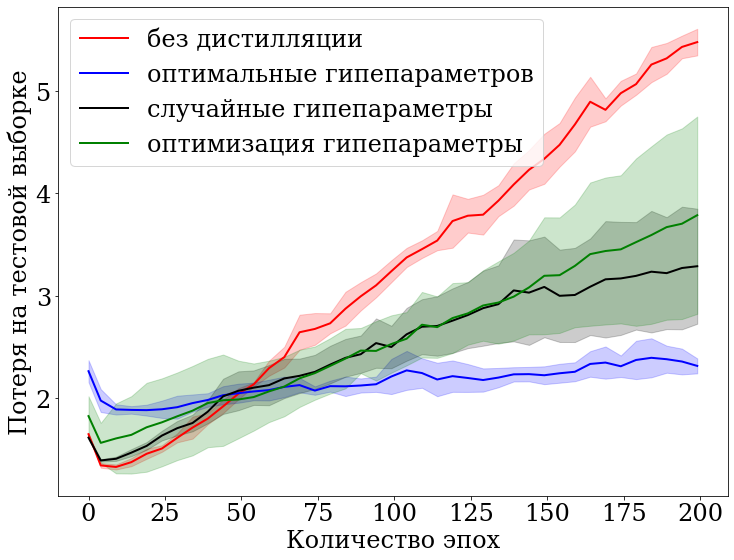

In [126]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('loss.pdf')

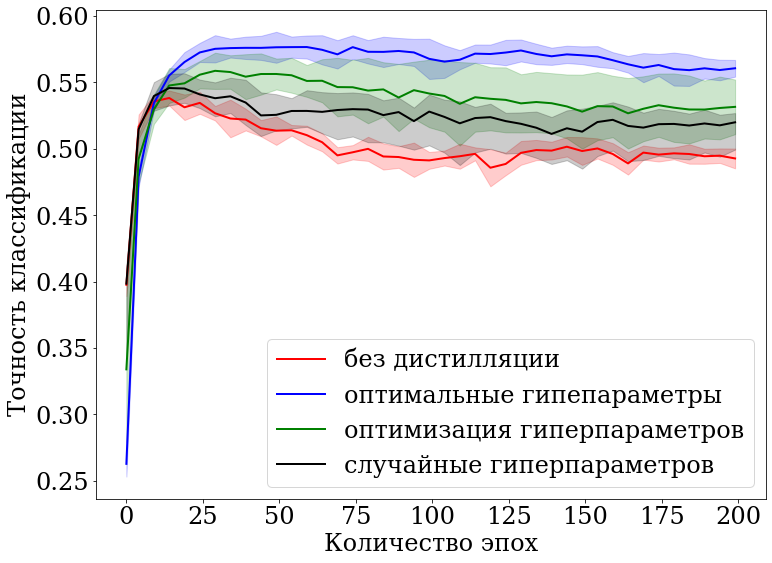

In [127]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, acc_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, acc_b.mean(1)-acc_b.std(1), acc_b.mean(1)+acc_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация гиперпараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='black', label='случайные гиперпараметров')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_h.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='black')


plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc.pdf')

In [46]:
epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
beta_d = np.array([data_d[2]['results'][i]['beta'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, beta_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, beta_d-beta_d.std(), beta_d+beta_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
beta_h = np.array([data_h[2]['results'][i]['beta'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, beta_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(epoch_h, beta_h-beta_h.std(), beta_h+beta_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('3.eps')

KeyError: 'beta'

In [47]:
epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
temp_d = np.array([data_d[2]['results'][i]['temp'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, temp_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, temp_d-temp_d.std(), temp_d+temp_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
temp_h = np.array([data_h[2]['results'][i]['temp'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, temp_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(temp_h, temp_h-temp_h.std(), temp_h+temp_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('4.eps')

KeyError: 'temp'

In [ ]:
"""
посмотреть, куда сходятся гиперпараметры.
Задача скорее всего невыпуклая по гиперпараметрам, поэтому может быть несколько точек экстремума.

Взять одно, наилучшее значение гиперпараметров.

Посчитать дистилляцию БЕЗ оптимизации гиперпараметров с наилушчими значениями.

НЕ ЗАБУДЬ ПОМЕНЯТЬ ИМЯ ФАЙЛА ДЛЯ СОХРАНЕНИЯ
"""

In [ ]:
"""
Посчитать дистилляцию с оптимизацей гиперпараметров, в качестве начальной точки взять не случайные значения,
а start_beta, start_temp.

НЕ ЗАБУДЬ ПОМЕНЯТЬ ИМЯ ФАЙЛА ДЛЯ СОХРАНЕНИЯ
"""

In [ ]:
"""
Построить график функции потерь на тесте в зависимости от эпохи. 
На графике должны быть линии для :
    - оптимизации без дистилляции
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график точности на тесте в зависимости от эпохи. 
На графике должны быть линии для :
    - оптимизации без дистилляции
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график беты в зависимости от эпохи. 
На графике должны быть линии для :    
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""

In [ ]:
"""
Построить график температуры в зависимости от эпохи. 
На графике должны быть линии для :    
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют start_temp, start_beta
    - оптимизации с дистилляцией без оптимизации гиперпараметров, значения соответсвутют оптимизированным значениям гиперпараметров
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение соответсвуeт start_temp, start_beta
    - оптимизации с дистилляцией c оптимизацией гиперпараметров, начальное приближение случайное
"""